**Кванториум СВДЖД**

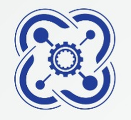




 **Тех. задание**
-------

Сегодня у клиентов медицинских учреждений существует запрос на круглосуточный доступ к медицинским сервисам и данным о своём здоровье. Подобные сервисы могут помогать пациентам интерпретировать результаты анализов, проводить первичную диагностику по описываемым симптомам.

В основе таких предсказательных сервисов лежат алгоритмы искусственного интеллекта, которые обучаются на основе реальных данных. Сбор подобных данных — ключевой этап разработки алгоритма искусственного интеллекта.

Часто медицинские данные представляют из себя текстовые протоколы пациентов, которые необходимо дополнительно обработать перед использованием. Этот процесс включает извлечение полезных характеристик: например, конкретных симптомов.

Разработать прототип медицинского рекомендательного алгоритма на основе машинного обучения.



#**Доп. задача:**
--
Создать новые признаки на основе имеющихся данных, которые впоследствии будут использоваться для более качественного обучения нашей модели для столбца "ПеренесенныеЗаболевания".

##Признаки:

1) MedicalRecordKey - int64, идентификатор медицинской записи, например 106627476

2) MedicalRecordDate - object, дата и время медицинской записи, например 2023-09-01 18:39:46.000

3) PatientKey - object, уникальный номер пациента, например 0xD8800629A4ADB5D792711AC5F17F72859E0F05FEB21E...

4) Возраст - int64,в днях, например 9764

5) Пол - float64,в бинарном значении, например 1.0

6) СпециальностьВрача - object, например Врач уролог

7) Жалобы - object, например На покраснение и шелушение кожи головы.

8) ПеренесенныеЗаболевания - object, например ГЭРБ ЖДА

9) ПеренесенныеОперации - object, например Стентирование коронарных артерий 05.02.2019г.

10) ПринимаемыеПрепараты - object, например монурал, канефрон.

#Библиотеки и загрузка файлов:

инсталляция библиотек

In [1]:
!python -m spacy download ru_core_news_sm #обработка натурального языка

2023-11-17 17:34:21.139261: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-11-17 17:34:21.139340: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-11-17 17:34:21.139391: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-11-17 17:34:21.164467: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-11-17 17:34:25.379503: W tensorflow/compiler/

In [2]:

!pip install pymorphy2 #библиотека лемматизации, морфологизации текстов. Будет применена для выделения признаков.

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.5/55.5 kB 1.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.2/8.2 MB 43.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for docopt: filename=docopt-0.6.2-py2.py3-none-any.whl size=13706 sha256=a522a7db426d1b6de35d0e667ae5ace67312fb5a32198ec1565626696a9d916c
  Stored in directory: /root/.cache/pip/wheels/fc/ab/d4/5da2067ac95b36618c629a5f93f809425700506f72c9732fac
Successfully built docopt


In [3]:
!pip install nltk #система распознавания названий и аббревиатур

In [4]:
!pip install natasha #библиотека для обработки русского языка

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.4/34.4 MB 39.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.7/46.7 kB 5.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for intervaltree: filename=intervaltree-3.1.0-py2.py3-none-any.whl size=26097 sha256=2f7b65f2c957750fedcd51de723ce84613fea5d2c82bf36ac7ba13fceb145eac
  Stored in directory: /root/.cache/pip/wheels/fa/80/8c/43488a924a046b733b64de3fac99252674c892a4c3801c0a61
Successfully built intervaltree


In [5]:
import pandas as pd #построение таблиц
import numpy as np #математическая обработка данных
import pymorphy2
import re #регулярные выражения
import nltk #обработка естественного языка
import os #для работы с файлами
from pymystem3 import Mystem #лемматизатор
from collections import Counter #словарь-счётчик
from nltk.tokenize import word_tokenize #токенизация

In [6]:
import natasha #для работы с русским языком
from natasha import ( #получение сегменаторов, парсеров, функции приведения текста в тип данных библиотеки из библиотеки Natasha
    Segmenter,
    NewsEmbedding,
    NewsMorphTagger,
    NewsSyntaxParser,
    Doc
)

segmenter = Segmenter()
emb = NewsEmbedding()
morph_tagger = NewsMorphTagger(emb)
syntax_parser = NewsSyntaxParser(emb)

In [7]:
import spacy #лемматизатор номер 2 :)
nlp = spacy.load("ru_core_news_sm")

In [8]:
morph = pymorphy2.MorphAnalyzer() #получение морфлогизатора из библиотеки pymorphy2
nltk.download('punkt') #алгоритм разделения текстов на предложения из библиотеки ntlk

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [9]:
#Опции для отображения pandas dataframe
pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_rows', 15000)

In [10]:
#Подключение гугл диска
try:
    from google.colab import drive
    drive.mount('/content/drive')
except Error:
    pass

Mounted at /content/drive


In [11]:
#Создание датафрейма, т.к работали с разных компьютеров добавлен алгоритм выбора правильного пути.
try:
    df = pd.read_csv("/content/drive/MyDrive/Hakaton/ж/медицинские_протоколы.csv", sep=';')
except FileNotFoundError:
    try:
        df = pd.read_csv("/content/drive/MyDrive/syrius_AI_medicine/reports.csv", sep=';')
    except FileNotFoundError:
        try:
            df = pd.read_csv("/content/drive/MyDrive/data кванториум/reports.csv", sep = ';')
        except FileNotFoundError:
            df = pd.read_csv("reports.csv", sep = ';')

# Первичный осмотр

In [12]:
#Первичный просмотр
def cool_output(s, n): #функция для понятного вывода данных и первичного анализа
    line = "*" * n
    padding = "-" * ((n - len(s)) // 2)
    if (n - len(s)) % 2 == 1:
        padding += "-"
    output = f"{line}\n{padding}{s}{padding}\n{line}"
    print(output)

def find_explicit_duplicates(df):
  ''' поиск явных дублирующихся значений, т.е строк которые полностью одинаковы '''
  explicit_duplicates = df[df.duplicated()]
  if not explicit_duplicates.empty:
      cool_output("Явные дубликаты", 80)
      display(explicit_duplicates)
  else:
      cool_output("Явных дубликатов не найдено", 80)
def allInfo(df):
  '''быстрый вывод статистики по датасету'''
  cool_output("Информация", 80)
  df_info = df.info() #стандартная функция вывода типов данных колонок
  cool_output("Типы данных", 80)
  display(df.dtypes.value_counts()) #вывод в скольки столбцах представлен этот тип данных
  cool_output("Размеры", 80)
  print(df.shape) #размер датасета
  cool_output("Первые три строки", 10 * len(df.columns))
  display(df.head(3)) #первые три строки
  cool_output("Последние три строки", 10 * len(df.columns))
  display(df.tail(3)) #последние три строки
  cool_output("Случайные три строки", 10 * len(df.columns))
  display(df.sample(3)) #случайные три строки
  cool_output("Уникальные значения", 80) #вывод количества и процентного соотношения уникальных значений
  for col in df.columns:
      unique_count = len(df[col].unique())
      unique_percentage = round(unique_count * 100 / df.shape[0], 2)
      print(f'"{col}": уникальных значений: {unique_count} ({unique_percentage}%)')
  cool_output("Пропуски", 80) #вывод количества и процентного соотношения пропусков
  for col in df.columns:
      missing_count = len(df[df[col].isna()])
      missing_percentage = round(missing_count * 100 / df.shape[0], 2)
      print(f'"{col}": пропусков: {missing_count} ({missing_percentage}%)')
  find_explicit_duplicates(df) #явные дубликаты
  cool_output("Статистика", 10 * len(df.columns))
  display(df.describe(include="all")) #стандартная статистическая функция
  footer = "".center(10 * len(df.columns), '-') #отступы для текста
  cool_output("", 10 * len(df.columns))
allInfo(df)

********************************************************************************
-----------------------------------Информация-----------------------------------
********************************************************************************
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12765 entries, 0 to 12764
Data columns (total 10 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   MedicalRecordKey         12765 non-null  int64  
 1   MedicalRecordDate        12765 non-null  object 
 2   PatientKey               12765 non-null  object 
 3   Возраст                  12765 non-null  int64  
 4   Пол                      12764 non-null  float64
 5   СпециальностьВрача       12765 non-null  object 
 6   Жалобы                   12765 non-null  object 
 7   ПеренесенныеЗаболевания  12417 non-null  object 
 8   ПеренесенныеОперации     9585 non-null   object 
 9   ПринимаемыеПрепараты     6971 non-null   object 


object     7
int64      2
float64    1
dtype: int64

********************************************************************************
-------------------------------------Размеры-------------------------------------
********************************************************************************
(12765, 10)
****************************************************************************************************
------------------------------------------Первые три строки------------------------------------------
****************************************************************************************************


,MedicalRecordKey,MedicalRecordDate,PatientKey,Возраст,Пол,СпециальностьВрача,Жалобы,ПеренесенныеЗаболевания,ПеренесенныеОперации,ПринимаемыеПрепараты
0,106627476,2023-09-01 18:39:46.000,0xA52FAC0660E364A3BD2338AD6749D320FF3E083382308F9D11886735C0C769CB,9764,1.0,Врач акушер гинеколог,на мажущие выделения из половых путей,"Факт получения травм, ожогов, ран, проведения медицинских манипуляций (инъекций, стоматологических, хирургических вмешательств и др.) в течение последних 30 дней отрицает, установление имплантата в течении 1 года отрицает. Перенесенные инфекционные заболевания, в т.ч. ВИЧ, вирусные гепатиты, туберкулез, COVID-19 отрицает.",Отрицает,Левотироксин 75 мкг/сут
1,106627477,2023-09-01 18:39:45.000,0xC03852BF5FDC992B86A87B1215BC47EBF66C1AB03F6D08C3391459D3C40D5E17,13814,1.0,Врач уролог,на дискомфорт при мочеиспускании на учащенное мочеиспускание,"Факт получения травм, ожогов, ран, проведения медицинских манипуляций (инъекций, стоматологических, хирургических вмешательств и др.) в течение последних 30 дней отрицает, установление имплантата в течении 1 года отрицает. Перенесенные инфекционные заболевания, в т.ч. ВИЧ, вирусные гепатиты, туберкулез, COVID-19 отрицает.",аппендэктомия 2013. кесарево сечение - преэклампсия (2018).,"монурал, канефрон."
2,106627482,2023-09-01 18:39:53.000,0x417FA75C8DAD480F952C6931B305A0218311A4BE61E28C537508BDAD57D9402D,10311,0.0,Врач дерматовенеролог,На покраснение и шелушение кожи головы.,ГЭРБ ЖДА,-,Колекальльциферол - 4000 МЕ Калия йодид Мальтофер - 2 т/день


****************************************************************************************************
----------------------------------------Последние три строки----------------------------------------
****************************************************************************************************


,MedicalRecordKey,MedicalRecordDate,PatientKey,Возраст,Пол,СпециальностьВрача,Жалобы,ПеренесенныеЗаболевания,ПеренесенныеОперации,ПринимаемыеПрепараты
12762,106627465,2023-09-01 18:39:24.000,0x3FEEB9EE504FE5396E8A7648DA7332A96AB15EB92F11759F748291A3395F5AB1,8429,0.0,Врач уролог,НАЛ жалобы на возникновение болевых ощущенив в висячей уретре после семяизвержения произошедшего любым путей ( в течение 5-6 месяцев).,"ОРВИ Факт получения травм, ожогов, ран, проведения медицинских манипуляций (инъекций, стоматологических, хирургических вмешательств и др.) в течение последних 30 дней отрицает, установление имплантата в течение 1 года отрицает. Перенесенные инфекционные заболевания, в т.ч. ВИЧ, вирусные гепатиты, туберкулез, COVID-19 отрицает.",нет,NaN
12763,106627471,2023-09-01 18:39:38.000,0xECD0944BDBDFD73E0CDB6F1C2A38D3052927BE1E865E7628E3FE1624583FE43B,22025,0.0,Врач кардиолог,"Нестабильность цифр АД, на повышение цифр АД до 150\90 мм ртс т на дискомфорт, тяжесть в левой половине грудной клетки, без четкой связи с физ. нагрузкой, перебои в работе сердца","Факт получения травм, ожогов, ран, проведения медицинских манипуляций (инъекций, стоматологических, хирургических вмешательств и др.) в течение последних 30 дней отрицает, установление имплантата в течении 1 года отрицает. Перенесенные инфекционные заболевания, в т.ч. ВИЧ, вирусные гепатиты, туберкулез, COVID-19 отрицает.",Стентирование коронарных артерий 05.02.2019г.,Неизвестен
12764,106627472,2023-09-01 18:39:41.000,0x11521B7C4C5115DADC3F54A0EE55082EEE5D4412EE5562471A9DA6DC41636A99,10906,0.0,Врач гастроэнтеролог,"изжога после приема пищи , переполнение в эпигастрии после еды , боль в эпигастрии ноющего характера после еды .неоформленый светлый стул","Факт получения травм, ожогов, ран, проведения медицинских манипуляций (инъекций, стоматологических, хирургических вмешательств и др.) в течение последних 30 дней отрицает, установление имплантата в течение 1 года отрицает. Перенесенные инфекционные заболевания, в т.ч. ВИЧ, вирусные гепатиты, туберкулез, COVID-19 отрицает.",NaN,NaN


****************************************************************************************************
----------------------------------------Случайные три строки----------------------------------------
****************************************************************************************************


,MedicalRecordKey,MedicalRecordDate,PatientKey,Возраст,Пол,СпециальностьВрача,Жалобы,ПеренесенныеЗаболевания,ПеренесенныеОперации,ПринимаемыеПрепараты
1774,106587133,2023-09-01 08:22:36.000,0x58D2F2B8773D9AEA8AD83073359724067F6B3E23F16A84336D355A25829F8543,14594,0.0,Врач оториноларинголог,"Жалобы на дискомфорт в горле осиплость , чувство наличия мокроты в горле",хронический тонзиллит хронический гастрит,Отрицает,Базисной терапии нет
502,106583624,2023-09-01 08:14:32.000,0xC2EF27508E795760F3A545A96B9211EC452917F531B94BB4B34FA633C70410D1,9241,0.0,Врач профпатолог,нет,"Факт получения травм, ожогов, ран, проведения медицинских манипуляций (инъекций, стоматологических, хирургических вмешательств и др.) в течение последних 30 дней отрицает, установление имплантата в течении 1 года отрицает. Перенесенные инфекционные заболевания, в т.ч. ВИЧ, вирусные гепатиты, туберкулез, COVID-19 отрицает.",NaN,NaN
21,106627613,2023-09-01 18:41:12.000,0xFF1A18AD2294B0A36BF7D2C01DEDB50892064AD2C7EB32A197FD09F5B5FA01A8,10429,1.0,Врач акушер гинеколог,"Жалобы на пузырьковые высыпания в области вульвы, болезненные. Обратилась по результатами обследования","Факт получения травм, ожогов, ран, проведения медицинских манипуляций (инъекций, стоматологических, хирургических вмешательств и др.) в течение последних 30 дней отрицает, установление имплантата в течении 1 года отрицает. Перенесенные инфекционные заболевания, в т.ч. ВИЧ, вирусные гепатиты, туберкулез, COVID-19 отрицает.",NaN,NaN


********************************************************************************
-------------------------------Уникальные значения-------------------------------
********************************************************************************
"MedicalRecordKey": уникальных значений: 12765 (100.0%)
"MedicalRecordDate": уникальных значений: 10966 (85.91%)
"PatientKey": уникальных значений: 10143 (79.46%)
"Возраст": уникальных значений: 7894 (61.84%)
"Пол": уникальных значений: 3 (0.02%)
"СпециальностьВрача": уникальных значений: 80 (0.63%)
"Жалобы": уникальных значений: 10384 (81.35%)
"ПеренесенныеЗаболевания": уникальных значений: 2631 (20.61%)
"ПеренесенныеОперации": уникальных значений: 4130 (32.35%)
"ПринимаемыеПрепараты": уникальных значений: 2281 (17.87%)
********************************************************************************
------------------------------------Пропуски------------------------------------
*******************************************************************

,MedicalRecordKey,MedicalRecordDate,PatientKey,Возраст,Пол,СпециальностьВрача,Жалобы,ПеренесенныеЗаболевания,ПеренесенныеОперации,ПринимаемыеПрепараты
count,1.276500e+04,12765,12765,12765.000000,12764.000000,12765,12765,12417,9585,6971
unique,NaN,10966,10143,NaN,NaN,80,10384,2630,4129,2280
top,NaN,2023-09-01 19:00:00.000,0x5A1B483537102D759D9E588BCFC9F2B76C3008E1B61FE68F97AC5619B6C90389,NaN,NaN,Врач терапевт,нет,"Факт получения травм, ожогов, ран, проведения медицинских манипуляций (инъекций, стоматологических, хирургических вмешательств и др.) в течение последних 30 дней отрицает, установление имплантата в течении 1 года отрицает. Перенесенные инфекционные заболевания, в т.ч. ВИЧ, вирусные гепатиты, туберкулез, COVID-19 отрицает.",Отрицает,Не отягощен
freq,NaN,9,10,NaN,NaN,1766,348,6473,1737,872
mean,1.066096e+08,NaN,NaN,13310.906541,0.619007,NaN,NaN,NaN,NaN,NaN
std,3.561485e+04,NaN,NaN,6015.442247,0.485650,NaN,NaN,NaN,NaN,NaN
min,1.065169e+08,NaN,NaN,6.000000,0.000000,NaN,NaN,NaN,NaN,NaN
25%,1.065963e+08,NaN,NaN,10113.000000,0.000000,NaN,NaN,NaN,NaN,NaN
50%,1.066083e+08,NaN,NaN,13301.000000,1.000000,NaN,NaN,NaN,NaN,NaN
75%,1.066215e+08,NaN,NaN,16892.000000,1.000000,NaN,NaN,NaN,NaN,NaN


****************************************************************************************************
----------------------------------------------------------------------------------------------------
****************************************************************************************************


Первичный просмотр показал:
1) Пропуски были найдены в столбцах: Пол, "ПеренесенныеЗаболевания", ПеренесенныеОперации, ПринемаемыеПрепараты.

2) Названия столбцов MedicalRecordKey, MedicalRecordDate, PatientKey на английском языке, а Возраст, Пол, СпециальностьВрача, Жалобы, "ПеренесенныеЗаболевания", ПеренесенныеОперации, ПринимаемыеПрепараты на русском языке, нужно перевести названия всех столбцов в нижний регистр и на английский язык, удалить лишние знаки препинания.

# Анализ данных и создание признаков

Задания для 2 этапа:

1) Выбрать 1 из двух текстовых колонок - "Жалобы" или "ПеренесенныеЗаболевания".

2) Провести простейший парсинг данных: разбить текст по знакам препинания (лучше - только  по запятым), привести текст к нижнему регистру и обрезать пробелы в начале и конце.

3) Получить на выходе список из Жалоб или Заболеваний (могут быть как из одного, так и из нескольких слов), отсортированный по частотности, встречаемости в тексте.

4) Отобрать топ-10 самых частых Жалоб или Заболеваний, учитывая суммарную частотность их различного написания (с сокращениями и опечатками).

5) Создать для полученного топ-10 правила продвинутого парсинга, объединяющего различные варианты написания Жалоб или Заболеваний и учитывающего морфологию слов. Можно использовать такие библиотеки для работы с русским языком как natasha.

6) С помощью построенных правил распарсить Жалобы или Заболевания и преобразовать их в новые бинарные признаки (новые колонки), где 1 будет означать наличие, а 0 - отсутствие соответствующих Жалоб или Заболеваний.

In [13]:
#Переименование столбцов по стандарту PEP-8
df = df.rename(columns = dict((i, i.lower()) for i in list(df))) #замена прописных букв строчными в исходных названиях

df = df.rename(columns = { #замена названий на более краткие и простые в запоминании
    "medicalrecordkey" : "record_id",
    "medicalrecorddate" : "date",
    "patientkey" : "patient_id",
    "возраст" : 'age',
    "пол" : "sex",
    "специальностьврача" : "speciality_of_doctor",
    "жалобы" : "problems",
    "перенесенныезаболевания" : "past_illnesses",
    "перенесенныеоперации" : "postponed_operations",
    "принимаемыепрепараты" : "medicicals_taken"
})

In [14]:
#Удаление лишних столбцов
df = df.drop('patient_id', axis=1) #индивидуальный номер каждой строки задается Pandas, значит id пациента нам не нужен
df = df.drop('record_id', axis=1)  #индивидуальный номер каждой строки задается Pandas, значит id записи нам не нужен
df = df.drop('date', axis=1) #все данные собраны в один день (см. первичный осмотр), дата нам не нужна точно

In [15]:
#Перевод возраста из дней в годы
def divise(row): #возвращает возраст в годах
  return row["age"] // 365
df['age'] = df.apply(divise, axis = 1) #применим функцию к колонке

In [16]:
#Подключение набора данных с кодфикаторами медицинских специальностей. Написана функция проверки пути, чтобы
#блокнот мог быть открыт на разных устройствах и с разных гугл-дисков
try:
    df_doctor_kinds = pd.read_csv("/content/drive/MyDrive/syrius_AI_medicine/doctor_types.csv", sep=';', encoding='cp1251')
except FileNotFoundError:
    try:
        df_doctor_kinds = pd.read_csv("/content/drive/MyDrive/data кванториум/doctor_types.csv", sep=';', encoding='cp1251')
    except FileNotFoundError:
        df_doctor_kinds = pd.read_csv("doctor_types.csv", sep=';', encoding='cp1251')

#удаление ненужных столбцов набора данных с кодфикаторами медицинских специальностей.
df_doctor_kinds = df_doctor_kinds.drop('PID', axis = 1)
df_doctor_kinds = df_doctor_kinds.drop('SERVICE_FIELD', axis = 1)

In [17]:
#форматирование столбца со специальностями врачей
def delete_dots_1(row):
    operable = 'NAME'
    value = row[operable]
    value = list(str(value))
    replaceables = set([',', '.', '?', '/', '-', '_', '(', ')', '!', ':', ';'])
    for i in range(len(value)):
        if value[i] in replaceables:
            value[i] = ' '
    value_txt = ""
    for i in value:
        value_txt = value_txt + i

    value = ' '.join(value_txt.split())
    return value.lower()

df_doctor_kinds['NAME'] = df_doctor_kinds.apply(delete_dots_1, axis=1)

In [18]:
#Удаление знаков препинания
def delete_dots(row):
    global operable
    value = row[operable]
    value = list(str(value))
    replaceables = set([',', '.', '?', '/', '-', '_', '(', ')'])
    for i in range(len(value)):
        if value[i] in replaceables:
            value[i] = ' '
    value_txt = ""
    for i in value:
        value_txt = value_txt + i

    value = ' '.join(value_txt.split())
    return value.lower()

operable = ""
for column in ['speciality_of_doctor', 'problems', "past_illnesses", "postponed_operations", "medicicals_taken"]:
    operable = column
    df[operable] = df.apply(delete_dots, axis = 1)

In [19]:
df["speciality_of_doctor"] = df["speciality_of_doctor"].replace("заведующий кабинетом ", '', regex = True)
df["speciality_of_doctor"] = df["speciality_of_doctor"].replace("заведующий отделением ", '', regex = True)
df["speciality_of_doctor"] = df["speciality_of_doctor"].replace("руководитель центра ", '', regex = True)
df["speciality_of_doctor"] = df["speciality_of_doctor"].replace("зав отделением ", '', regex = True)
df["speciality_of_doctor"] = df["speciality_of_doctor"].replace(" процедурной", '', regex = True)
df["speciality_of_doctor"] = df["speciality_of_doctor"].replace("медицинская сестра", 'медицинская сестра медицинский брат медбрат', regex = True)
df["speciality_of_doctor"] = df["speciality_of_doctor"].replace("заведюущий отделением ", '', regex = True)

In [20]:
#Создание целочисленного признака для специальности врача

def doctor_id(row):
    id = int(df_doctor_kinds.loc[df_doctor_kinds['NAME'] == row['speciality_of_doctor']]['ID'])
    return id

df['speciality_of_doctor'] = df.apply(doctor_id, axis = 1)  # применим

Простейший парсинг строки по знакам препинания

In [21]:
#Удаление пропусков в стобце "sex" и привидение его к целочисленному формату
df = df.dropna(subset = 'sex')
df['sex'] = df['sex'].astype(int) #приведение пола к целочисленному типу

<ipython-input-21-8f47ba50d349>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['sex'] = df['sex'].astype(int) #приведение пола к целочисленному типу


Нами для обработки была выбрана колонка с перенесёнными заболеваниями

Проведём очистку данных с применением токенизации

При нахождении токена из списка удалим его, и все завсимые. Это позволит нам избавиться от информации о отрицаемых пациентом заболеваниях (т.е отсутствующих у него), как от несущественной и мешающей анализу данных

Примерная визуализация алгоритма для одного конкретного пациента:

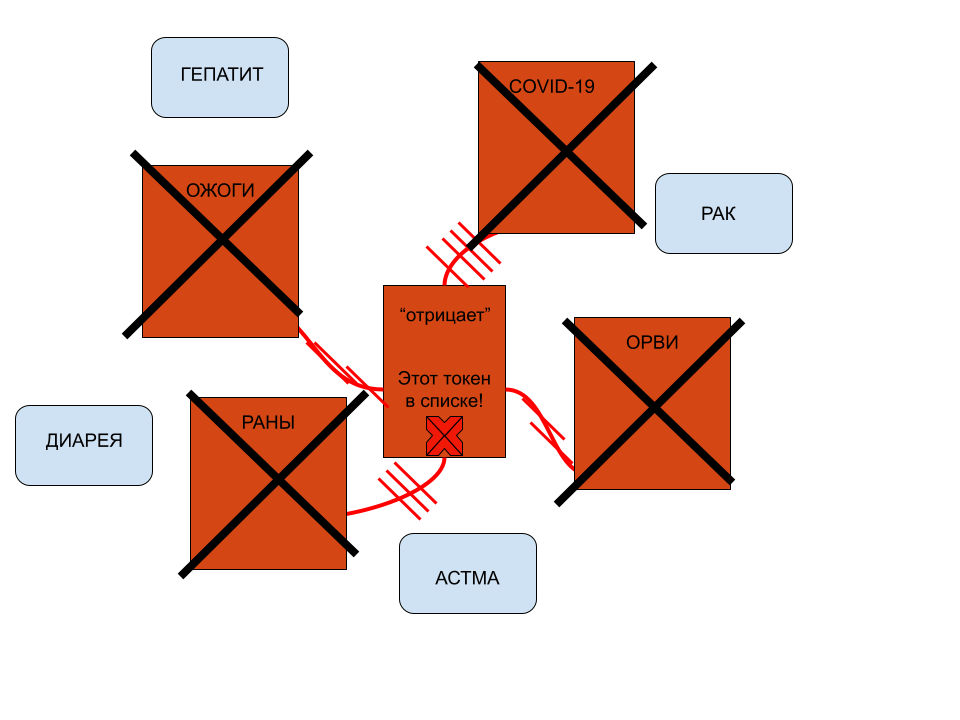

In [22]:
#Обнуление строк, в которых нет информации о заболеваниях
def nullify_rows(text, texts_to_nullify):
    # Обработаем текст с использованием spaCy
    doc = nlp(text)

    # Создадим список индексов токенов для удаления
    tokens_to_remove = set()

    for i, token in enumerate(doc):
        # Проверим, содержится ли подстрока в текущем токене
        if any(substring in token.text for substring in texts_to_nullify):
            # Добавим индекс текущего токена
            tokens_to_remove.add(i)
            # Добавим индексы всех зависимых токенов
            tokens_to_remove.update([descendant.i for descendant in token.subtree])

    # Создадим новый документ, исключив токены для удаления
    new_doc = spacy.tokens.Doc(doc.vocab, words=[token.text for i, token in enumerate(doc) if i not in tokens_to_remove])

    # Соберем оставшиеся токены обратно в строку
    result_text = ' '.join(token.text for token in new_doc)

    if result_text == '':
        return '0'

    return result_text

texts_to_nullify = ["факт получения травм ожогов ран проведения медицинских манипуляций", "-", "отриц", "не бы", "не отмеч", "отр", "нет", "не отмечает"]

df['past_illnesses'] = df['past_illnesses'].apply(lambda x: nullify_rows(x, texts_to_nullify))

In [23]:
#Обнуление значений перенесенных операций, в которых нет информации о операциях

df["postponed_operations"] = df["postponed_operations"].replace("отриц", 0, regex = True)
df["postponed_operations"] = df["postponed_operations"].replace("отр", 0)
df["postponed_operations"] = df["postponed_operations"].replace("нет", 0)
df["postponed_operations"] = df["postponed_operations"].replace("не бы", 0, regex = True)
df["postponed_operations"] = df["postponed_operations"].replace("-", 0)
df["postponed_operations"] = df["postponed_operations"].replace("nan", 0)
df["postponed_operations"] = df["postponed_operations"].replace("", 0)


In [24]:
df.head(800)

,age,sex,speciality_of_doctor,problems,past_illnesses,postponed_operations,medicicals_taken
0,26,1,12,на мажущие выделения из половых путей,0,0,левотироксин 75 мкг сут
1,37,1,86,на дискомфорт при мочеиспускании на учащенное мочеиспускание,0,аппендэктомия 2013 кесарево сечение преэклампсия 2018,монурал канефрон
2,28,0,20,на покраснение и шелушение кожи головы,гэрб жда,0,колекальльциферол 4000 ме калия йодид мальтофер 2 т день
3,62,1,182,подписано информированное добровольное согласие на получение первичной медико санитарной помощи прием кардиолога повторно жалобы на фоне стресса повышение ад 145 90 ммрттс с головными болями 2 балла по ваш на эпизоды учащенного сердцебиения без четкой связи с физической нагрузкой перебои в работе сердца,узловой зоб,аппендицит в 15 летнем возрасте удаление кисты бартолиниевой железы в 2007 г в 2022г мастэктоия слева,на пенициллиновый ряд отек квинке сульфаниламиды крапивница на метронидазол чувство дурноты
4,42,1,12,жалобы на болезненность и нагрубание правой молочной железы,0,аппендэктомия в 5 лет импланты молочных желез 2016 лазерная коррекция миопии 2017,не отягощен
5,35,1,83,на боли в левом коленном суставе,0,лазерная коррекция зрения,не отягощен
6,36,0,182,на повышение ад до 150\100 мм рт ст,0,0,nan
7,58,1,16,жалобы на отрыжку периодическую тяжесть в животе эпигастральной области правом подреберье после еды периодическое вздутие живота дискомфорт при дефекации,0,мастэктомия левой м ж июль 2022 комбинированное лечение,nan
8,40,1,37,жалобы на частые головные боли ноющие по ваш на 5 6б чаще в затылочной области до тошноты двоение в глазах появление молний лучей и вспышек чаще утром фото и фонофобия присутствует при движении головная боль усиливается жалобы на боли в шейном поясничном отделе позвоночника по ваш на 5 6 иногда онемение левой руки периодически,0,0,nan
9,34,0,16,на ноющие боли в правом подреберье,0,0,nan


In [25]:
#Обнуление значений перенесенных заболеваний, в которых нет информации о принимаемых лекарствах
df["medicicals_taken"] = df["medicicals_taken"].replace("не отяг", 0, regex = True)
df["medicicals_taken"] = df["medicicals_taken"].replace("отриц", 0, regex = True)
df["medicicals_taken"] = df["medicicals_taken"].replace("отр", 0)
df["medicicals_taken"] = df["medicicals_taken"].replace("нет", 0)
df["medicicals_taken"] = df["medicicals_taken"].replace("базисной терапии нет", 0, regex = True)
df["medicicals_taken"] = df["medicicals_taken"].replace("-", 0)
df["medicicals_taken"] = df["medicicals_taken"].replace("nan", 0)
df["medicicals_taken"] = df["medicicals_taken"].replace("неизвестен", 0)
df["medicicals_taken"] = df["medicicals_taken"].replace("не принимает", 0, regex = True)


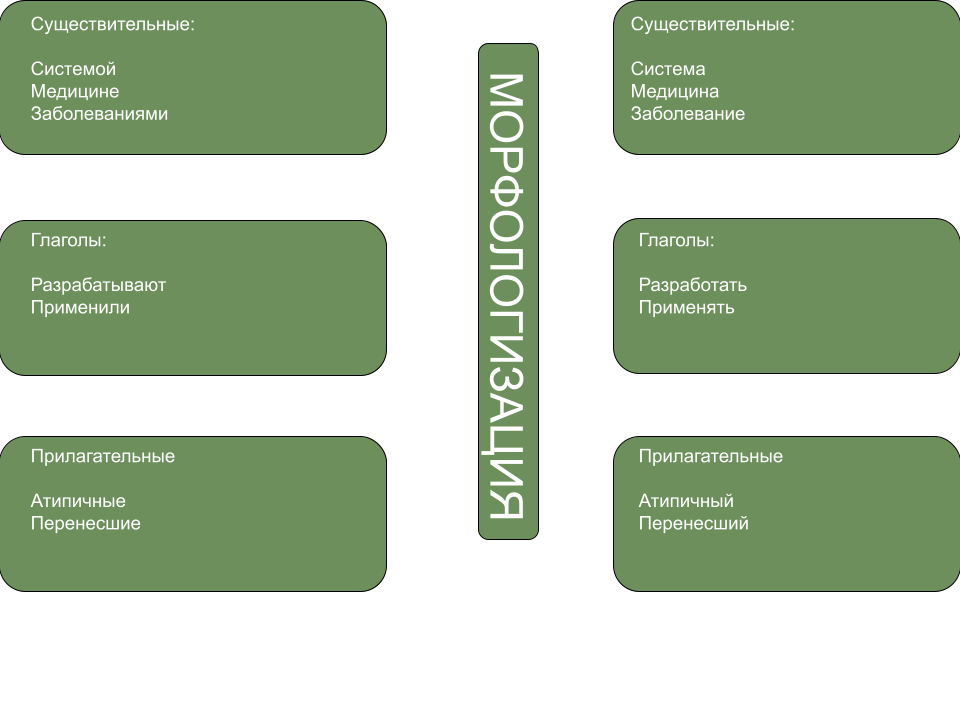

In [26]:
#Вывод названия заболевания
''' названия заболеваний - это чаще всего прилагательные и существительные. Могут быть и глаголы, например
#прогрессирующий синдром ..., но в данном случае нам досточно будет существительных с прилагательными, обучение модели
будет проще'''
def extract_noun(text): #берет список перенесенных заболеваний и если его часть распознана как существительное
#или прилагательное возвращает эту часть, также приводит к словарному виду
    if text == 0:
        return 0
    words = re.findall(r'\b\w+\b', text) #поиск всех слов в тексте перенесённых заболеваний
    result = []

    for word in words:
        parsed_word = morph.parse(word)[0] #узнать, к какой части речи относится данное слово
        if 'NOUN' in parsed_word.tag and 'nomn' in parsed_word.tag:
            result.append(parsed_word.word)


    return ', '.join(result)
df['proc_past_illnesses'] = df['past_illnesses'].apply(extract_noun)

In [27]:
#Удаление знаков препинания в колонке перенесённых заболеваний (, установленные на прошлом шаге)
def delete_dots(row):
    ''' на вход поступает текст, на выход - текст без знаков препинания '''
    global operable
    value = row[operable]
    value = list(str(value))
    replaceables = set([',', '.', '?', '/', '-', '_', '(', ')', '[', ']', "'"])
    for i in range(len(value)):
        if value[i] in replaceables:
            value[i] = ' '
    value_txt = ""
    for i in value:
        value_txt = value_txt + i

    value = ' '.join(value_txt.split())
    return value.lower()

operable = ""

for column in ["proc_past_illnesses"]:
    operable = column
    df[operable] = df.apply(delete_dots, axis = 1)

In [28]:
'''Замена орз (весьма распространненного вида заболеваний в датасете) на орви для уменьшения количества небольших классов
заболеваний'''

df['proc_past_illnesses'] = df['proc_past_illnesses'].str.replace('орз', 'орви')

In [29]:
#Подсчет количества найденных заболеваний каждого типа
df['proc_past_illnesses'] = df['proc_past_illnesses'].apply(lambda x: word_tokenize(x.lower())) #оставим только
#найденные ключевые слова в столбце

word_counts = Counter()

for _, row in df.iterrows():
    word_counts.update(row['proc_past_illnesses'])

for word, count in word_counts.items():
    pass

In [30]:
#Удаление знаков препинания, которые появляются в результате преобразования
df['proc_past_illnesses'] = df['proc_past_illnesses'].astype(str)
operable = ""
for column in ["proc_past_illnesses"]:
    operable=column
    df[operable] = df.apply(delete_dots, axis=1)

In [31]:
#Удаление некоторых значений, которые мешают анализу данных, не неся в себе полезной нагрузки
word_to_remove_1 = 'болезнь'
word_to_remove_2 = 'ст'
word_to_remove_3 = 'ремиссия'

if word_to_remove_1 in word_counts:
    del word_counts[word_to_remove_1]
if word_to_remove_2 in word_counts:
    del word_counts[word_to_remove_2]
if word_to_remove_3 in word_counts:
    del word_counts[word_to_remove_3]

In [32]:
# Вывод 10 самых релевантных ответов
sorted_word_counts = sorted(word_counts.items(), key=lambda x: x[1], reverse=True) #сортировка по частотности встречи
#болезни в столбце

for word, count in sorted_word_counts[:10]:
    print(f'{word} : {count} раз')

орви : 491 раз
гастрит : 322 раз
тонзиллит : 167 раз
цистит : 101 раз
пиелонефрит : 85 раз
оспа : 76 раз
зоб : 75 раз
гипотиреоз : 62 раз
мг : 57 раз
переломы : 48 раз


In [33]:
#Создание новых столбцов для распарсинга колонки с перенесёнными заболеваниями
labels = [word for word, _ in sorted_word_counts]

for i in list(labels)[:10]:
    df.insert(len(list(df)), i, 0)

In [34]:
#Заполнение новых столбцов
cols = labels[:10]
def parser(row): #функция распарсинга заболеваний по столбцам
    ''' на вход - список заболеваний пациентов, функция расставляет 1 в колонках распространённых заболеваний если таковое имеется у пациента, иначе оставляет 0'''
    dat = row['proc_past_illnesses'].split()
    flag = 0
    for i in dat:
        if i in cols:
            row[i] = 1
            flag = 1
    return row

df = df.apply(parser, axis = 1)

# Финальный результат

Стоит отметить ,что не все из импортированных библиотек были нами использованы, но все из них были испытаны на данных. В результате наших испытаний, именно то сочетание библиотек которое вы видите здесь показало себя наиболее понятным и эффективным.

In [35]:
#Импорт окончательного результата в csv
df.to_csv('res.csv', index = False)

In [38]:
df.head() #просмотреть результат

,age,sex,speciality_of_doctor,problems,past_illnesses,postponed_operations,medicicals_taken,proc_past_illnesses,орви,гастрит,тонзиллит,цистит,пиелонефрит,оспа,зоб,гипотиреоз,мг,переломы
0,26,1,12,на мажущие выделения из половых путей,0,0,левотироксин 75 мкг сут,,0,0,0,0,0,0,0,0,0,0
1,37,1,86,на дискомфорт при мочеиспускании на учащенное мочеиспускание,0,аппендэктомия 2013 кесарево сечение преэклампсия 2018,монурал канефрон,,0,0,0,0,0,0,0,0,0,0
2,28,0,20,на покраснение и шелушение кожи головы,гэрб жда,0,колекальльциферол 4000 ме калия йодид мальтофер 2 т день,,0,0,0,0,0,0,0,0,0,0
3,62,1,182,подписано информированное добровольное согласие на получение первичной медико санитарной помощи прием кардиолога повторно жалобы на фоне стресса повышение ад 145 90 ммрттс с головными болями 2 балла по ваш на эпизоды учащенного сердцебиения без четкой связи с физической нагрузкой перебои в работе сердца,узловой зоб,аппендицит в 15 летнем возрасте удаление кисты бартолиниевой железы в 2007 г в 2022г мастэктоия слева,на пенициллиновый ряд отек квинке сульфаниламиды крапивница на метронидазол чувство дурноты,зоб,0,0,0,0,0,0,1,0,0,0
4,42,1,12,жалобы на болезненность и нагрубание правой молочной железы,0,аппендэктомия в 5 лет импланты молочных желез 2016 лазерная коррекция миопии 2017,0,,0,0,0,0,0,0,0,0,0,0
